In [2]:
library(igraph)
library(tidyverse)
library(ggplot2)
library(RColorBrewer)
library(rgl)
library(compiler)

In [3]:
survived <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- order(V(g)$load, decreasing = TRUE)[1]

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived <- cmpfun(survived)

In [4]:
survived_deg <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- order(degree(g), decreasing = TRUE)[1]

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived_deg <- cmpfun(survived_deg)

In [5]:
survived_random <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- sample(x = 1:length(g), size = 1)

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived_random <- cmpfun(survived_random)

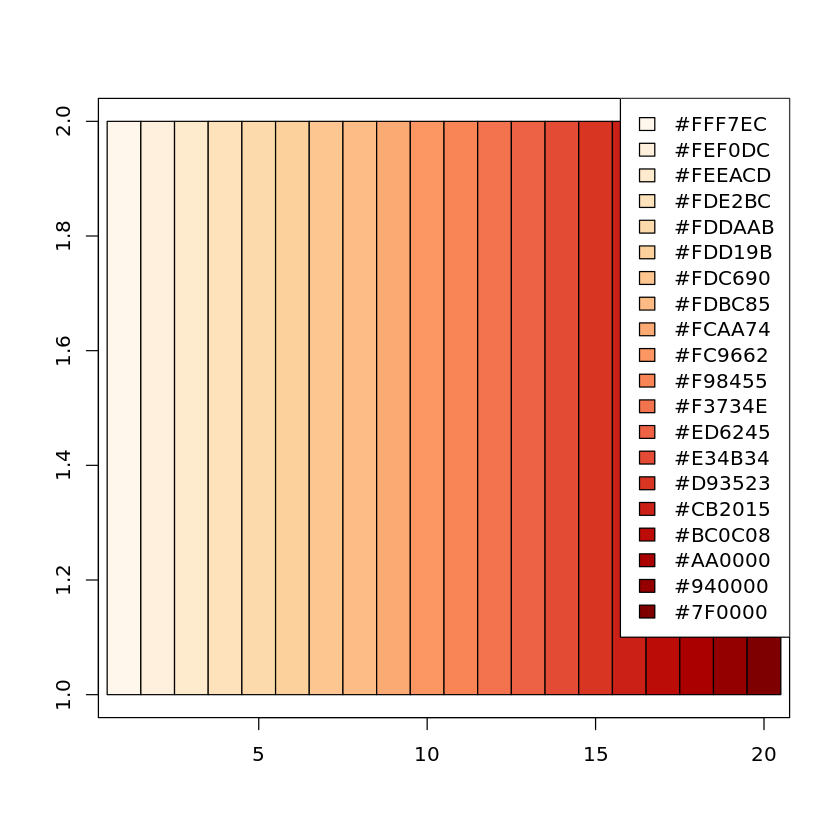

In [6]:
mypal <- rev(colorRampPalette(rev(c(brewer.pal(9, "OrRd"))))(20))
plot(1, 1, type = "n", xlim = c(1, length(mypal)), ylim = c(1, 2), xlab = "", ylab = "")
for (i in 1:length(mypal)) {
  rect(i - 0.5, 1, i + 0.5, 2, col = mypal[i])
}
legend("topright", legend = mypal, fill = mypal, bg = "white")

In [7]:
# mypal

In [342]:
nodes<-read.csv('internet/nodes_clean.csv')
edges<-read.csv('internet/edges.csv')

In [343]:
colnames(nodes)

[1] "X..index" "as_id"    "X_pos"

In [344]:
head(edges)

,X..source,target
,<int>,<int>
1,0,3490
2,1,701
3,1,2914
4,1,2828
5,1,286
6,1,293


In [345]:
layout<-as.matrix(nodes[,c(2,3)],rownames.force = F)
layout <- layout.norm(layout, -1, 1, -1, 1)

In [346]:
head(layout)

as_id,X_pos
-0.35419655,-0.26764828
-0.03564651,-0.20763614
-0.25647477,-0.07705896
0.12450623,-0.26076969
0.32171658,-0.40192561
-0.04838580,-0.35253494


In [347]:
el<-as.matrix(edges+1)
g<-graph_from_edgelist(el = el, directed = FALSE)

In [348]:
btw<-betweenness(g, normalized=FALSE,  directed = F)

In [349]:
index <- which.max(btw)

In [350]:
btw_log <- log(1+btw)

In [351]:
# normalize and convert to integer between 1 and 20
btw_col_idx <- 1 + floor((19)*(btw_log - min(btw_log))/(max(btw_log)-min(btw_log)))

In [352]:
colors<-mypal[btw_col_idx]

In [353]:
# mypal[bet][3782]<-'#0000FF'

In [354]:
ei <- incident(g, index, mode = 'all')
E(g)$color_cst<-'grey'
E(g)[ei]$width_cst<-0.5
E(g)[-ei]$width_cst<-NA
E(g)[ei]$color_cst<-'grey40'
E(g)[-ei]$color_cst<-'grey60'

In [226]:
pdf("internet/whole_graph.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=1.5, cex.lab = 1.5, cex.main=2)
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)


x_left_1<--0.2
x_right_1<--0.1
y_top_1<--0.15
y_bottom_1<--0.25

x_left_2<-0.1
x_right_2<-0.6
y_top_2<--0.5
y_bottom_2<--1

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = NA, vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,
     xlab='x dimension [au]', ylab='y dimension [au]',
#      xlim = c(0.2,0.8),
#      ylim = c(0.2, 0.6),
     rescale=F )
points(layout[index,1], layout[index,2], lwd=15, col='blue')
grid()
rect(xleft = x_left_1, xright = x_right_1, ytop = y_top_1, ybottom = y_bottom_1, lwd = 2)
rect(xleft = x_left_2, xright = x_right_2, ybottom = y_bottom_2, ytop =y_top_2, lwd = 2)
legend(-1, 1, legend=c(paste('Degree of selected node:', degree(g, v =index)),
                       paste('Betweenness of node:', format(btw[index], scientific = TRUE))),
       bg='white', cex=2)

plot(g, layout = layout, vertex.size = 0.5, vertex.frame.color = NA, vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,edge.color=E(g)$color_cst, edge.width=E(g)$width_cst,
     axes = T,main='Zoom on node of highest btw',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1], layout[index,2], lwd=15, col='blue')
grid()

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = 0.1, #vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T, main='Zoom on detail',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )
# points(layout[index,1], layout[index,2], lwd=15, col='blue')
grid()
dev.off()

png 
  2

In [355]:
deg_graph<-degree(g)

In [356]:
fit_res<-fit_power_law(deg_graph, xmin = 1)

In [357]:
fit_res

$continuous
[1] FALSE

$alpha
[1] 1.80072

$xmin
[1] 1

$logLik
[1] -13356.29

$KS.stat
[1] 0.1761675

$KS.p
[1] 0

In [358]:
f <- function(g, x) {
    function(x) {
        x^-g
    }
}

In [359]:
f2<-f(2)
f3<-f(3)
f_c<-f(fit_res$alpha)

In [360]:
deg_dist<-degree_distribution(g)

In [361]:
fitting_df <- data.frame(k = 1:19, p = ifelse(is.finite(log(deg_dist)[2:20]), log(deg_dist)[2:20],
    NA))

In [362]:

linear_model <- lm(p ~ k, data=fitting_df)

In [238]:
pdf("internet/deg_distrib.pdf",width=14, height = 10) 

layout.matrix <- matrix(c(1, 1, 1, 1, 2, 0), nrow = 2, ncol = 3)
lay_plots <- layout(mat = layout.matrix)


x_min <- 1
x_max <- 100
# options(repr.plot.width = 14, repr.plot.height = 7)
par(cex.axis = 1.5, cex.lab = 2, cex.main = 1, oma=c(2,2,2,2))
plot(1:19, deg_dist[2:20], xlab = "Degree k", ylab = "Prob(k)", pch = 16, cex = 2.3,
    xlim = c(1, 30), log = "xy")
curve(f_c, from = x_min, to = x_max, add = T, log = "xy", col = "red", lwd = 3)
curve(f2, from = x_min, to = x_max, add = T, log = "xy", col = "blue", lwd = 3)
curve(f3, from = x_min, to = x_max, add = T, log = "xy", col = "darkgreen", lwd = 3)
grid()
legend("bottomleft", legend = c(paste("Fit pwr law:", round(fit_res$alpha,2)), "gamma=2", "gamma=3"), col = c("red",
    "blue", "darkgreen"), lty = 1, lwd = 3, cex = 2)

plot(1:19, log(deg_dist[2:20]), xlab = "Degree k", ylab = "log(prob(k))", pch = 16,
    cex = 1.3, xlim = c(1, 22))
abline(a = linear_model$coefficients[[1]], b = linear_model$coefficients[[2]])
grid()
legend('topright', legend=c('Linear model'), lwd=2, lty=1, cex=2)
dev.off()

png 
  2

In [363]:
betwe<-betweenness(g, normalized=FALSE)

In [240]:
pdf("internet/betwe_distrib.pdf",width=7, height = 7) 

par(mar = c(5, 4, 4, 4) + 0.3)
h <- hist(log(betwe), breaks = 18, probability = T, xlab = "Log(btw)", ylab = "P(log(btw))",
    main = "Betweenness distribution", col = "orange", )
par(new = TRUE)
h$counts <- cumsum(h$counts)/sum(h$counts)
plot(h, axes = FALSE, xlab = "", ylab = "", main='', density = 90, col=alpha('blue',0.3) )
axis(side = 4, at = pretty(c(0, 1)))
mtext("Cumulative P(log(btw))", side = 4, line = 3)
grid()
dev.off()

png 
  2

In [364]:
densi<-data.frame(bet=btw, deg=degree(g))

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


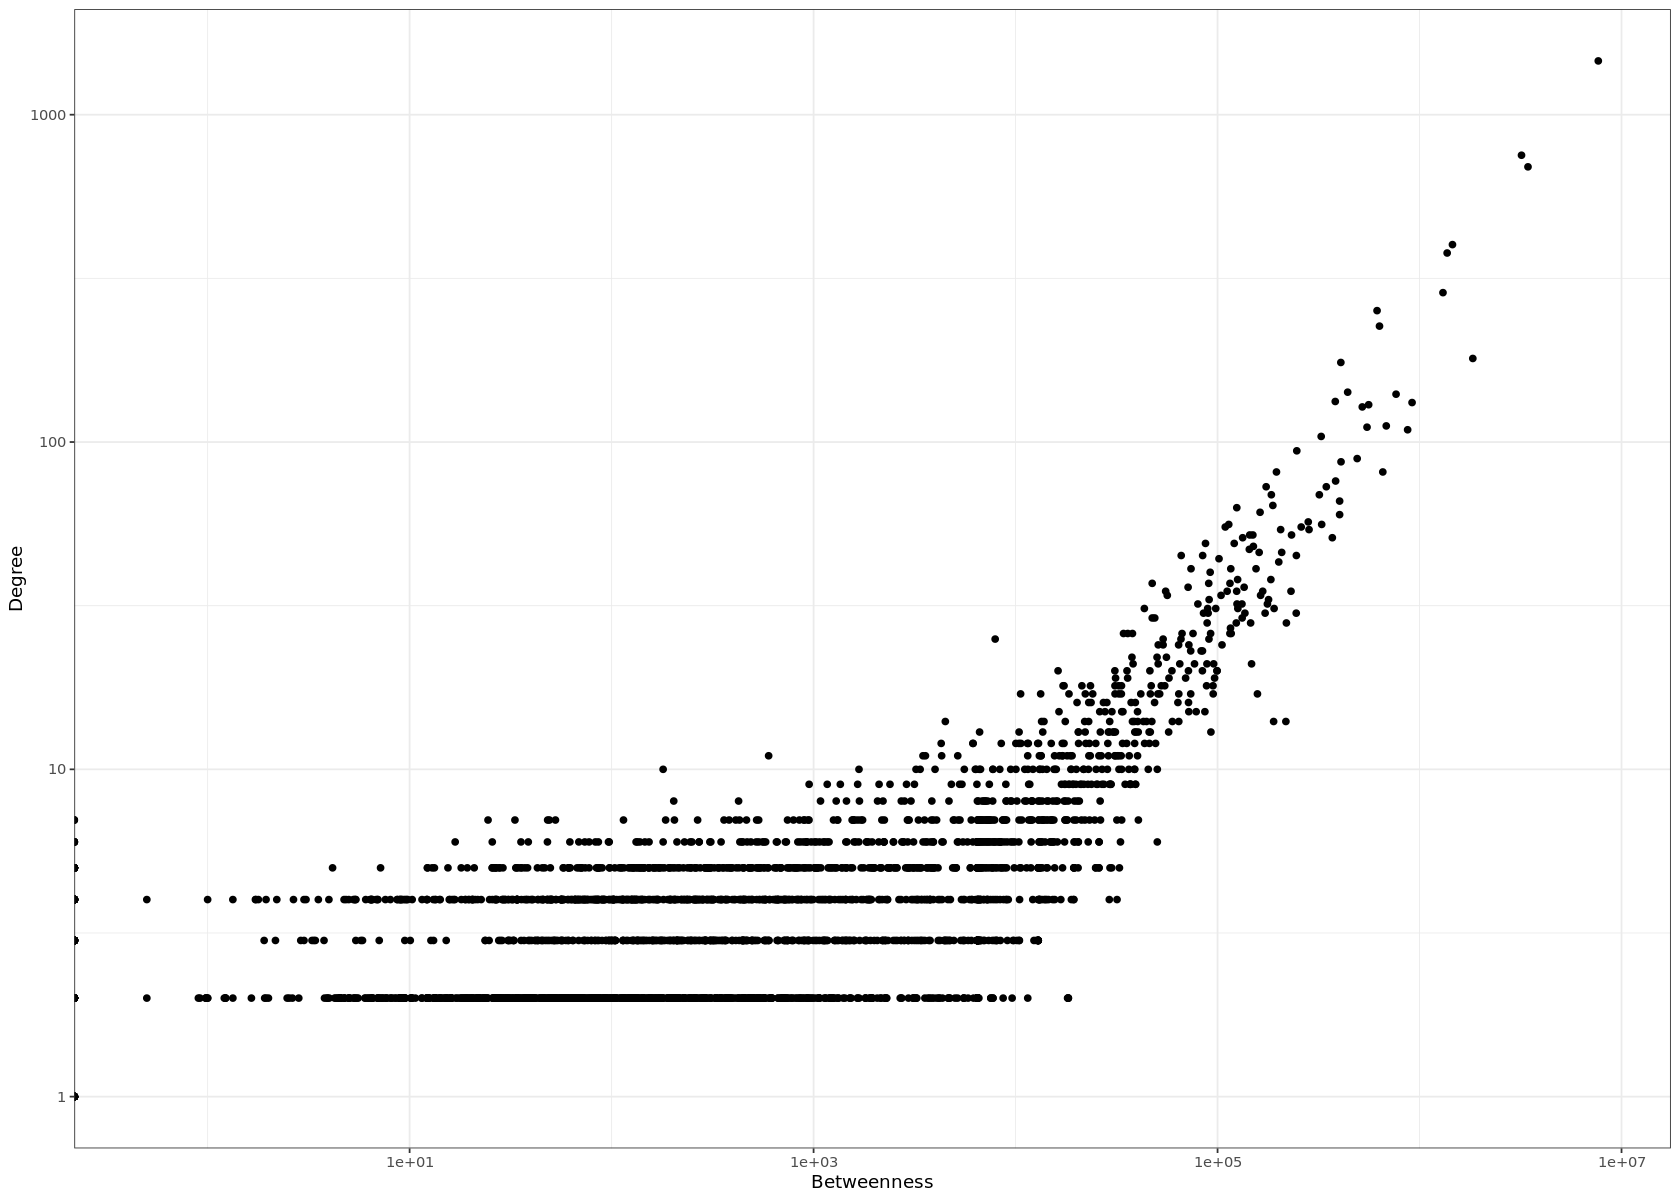

In [273]:
bet_deg<-ggplot(densi, aes(x = btw, y = deg)) + geom_point() + scale_y_log10() + scale_x_log10() +
    theme_bw()+labs(x='Betweenness', y='Degree')
bet_deg
ggsave(plot = bet_deg, filename = 'internet/between_deg_correlation.pdf', width = 7, height = 7,scale = 0.75)

# analysis of tear down at different alpha
refer to script

In [28]:
# alphas <- seq(from = 0, to = 5, by = 0.5)

# g_ratio <- vector()
# g_ratio_deg <- vector()
# g_ratio_random <- vector()
# for (i in seq_along(alphas)) {
#     g_ratio[i] <- survived(g, alpha = alphas[i])
#     g_ratio_deg[i] <- survived_deg(g, alpha = alphas[i])
#     g_ratio_random[i] <- survived_random(g, alpha = alphas[i])
# }

# alphas_zoom <- seq(from = 0.1, to = 1.5, by = 0.1)

# g_ratio_zoom <- vector()
# g_ratio_deg_zoom<-vector()
# g_ratio_random_zoom<-vector()
# for (i in seq_along(alphas_zoom)) {
#     g_ratio_zoom[i] <- survived(g, alpha = alphas_zoom[i])
#     g_ratio_deg_zoom[i]<- survived_deg(g, alpha=alphas_zoom[i])
#     g_ratio_random_zoom[i] <- survived_random(g, alpha = alphas_zoom[i])

# }

# plot(alphas, g_ratio)
# plot(alphas, g_ratio_random, add=T, col='red')

# g_ratio_zoom

# plot(alphas_zoom, g_ratio_zoom)
# plot(alphas_zoom, g_ratio_random_zoom, col='red')

In [334]:
g_ratios<-read.csv('internet/plot_g.csv')

In [335]:
g_ratios

X,alpha,g_ratio,g_ratio_sd,type
<int>,<dbl>,<dbl>,<dbl>,<chr>
1,0.00,0.08371949,0.000000e+00,Betw Targeted
2,0.05,0.07568736,0.000000e+00,Betw Targeted
3,0.10,0.10071053,0.000000e+00,Betw Targeted
4,0.15,0.11569354,0.000000e+00,Betw Targeted
5,0.20,0.22984245,0.000000e+00,Betw Targeted
6,0.25,0.29904232,0.000000e+00,Betw Targeted
7,0.30,0.42477603,0.000000e+00,Betw Targeted
8,0.40,0.61244980,0.000000e+00,Betw Targeted
9,0.50,0.76150757,0.000000e+00,Betw Targeted


Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


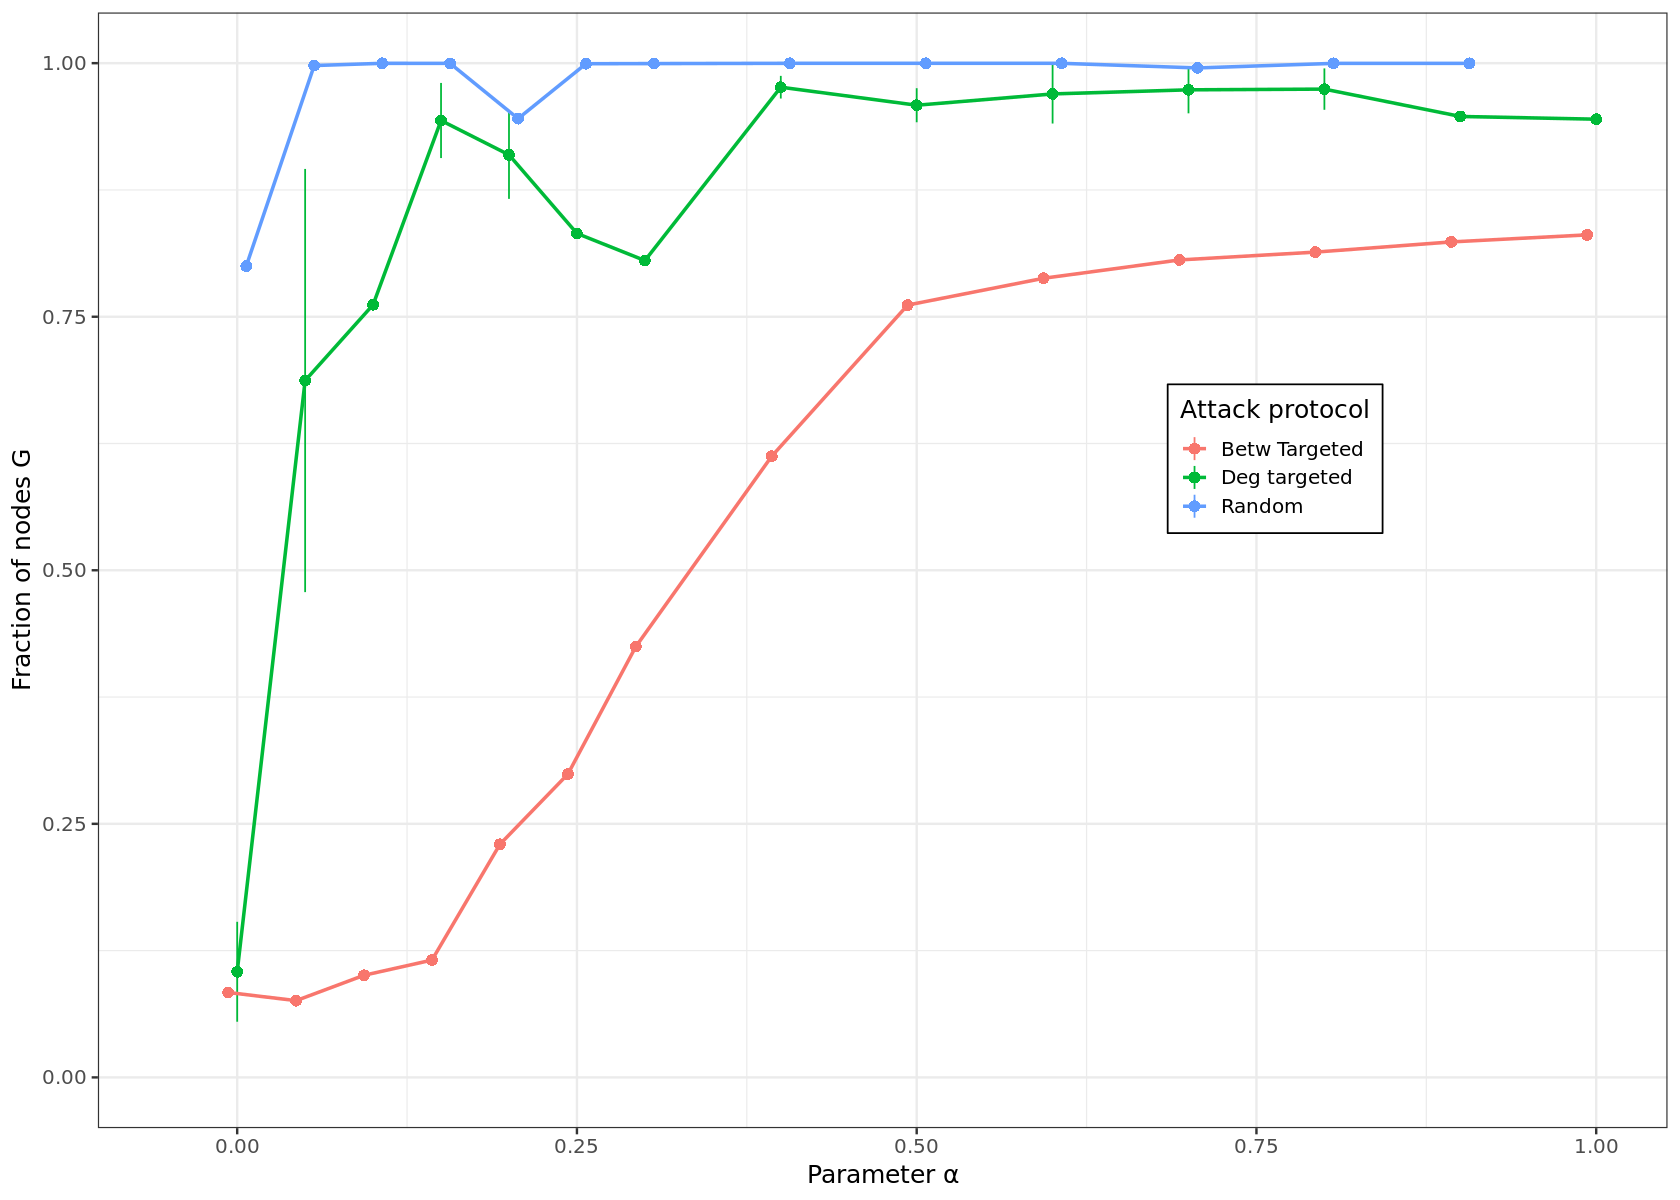

In [336]:
plot_conf <- ggplot(g_ratios) + geom_point(aes(x = alpha, y = g_ratio, col = type),
    shape = 16, size = 3, position = position_dodge(0.02)) + geom_linerange(aes(x = alpha,
    ymax = g_ratio + g_ratio_sd, ymin = g_ratio - g_ratio_sd, col = type), position = position_dodge(-0.02)) +
    geom_line(aes(x = alpha, y = g_ratio, col = type), linewidth = 1, position = position_dodge(0.02)) +
    scale_x_continuous(limits = c(-0.05, 1)) + labs(x = expression(paste("Parameter ",
    alpha)), y = "Fraction of nodes G", col = "Attack protocol") + theme_bw(base_size = 15) +
    theme(legend.position = c(0.75, 0.6), legend.background = element_rect(size = 0.5,
        linetype = "solid", colour = "black"))+ylim(0,1)

plot_conf

In [337]:
ggsave(plot = plot_conf, filename = 'internet/plot_g.pdf', width = 7, height = 5)

Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


In [338]:
g_ratios %>% filter(type=='Betw Targeted') -> g_ratios_2

Warning message:
“`position_dodge()` requires non-overlapping x intervals”


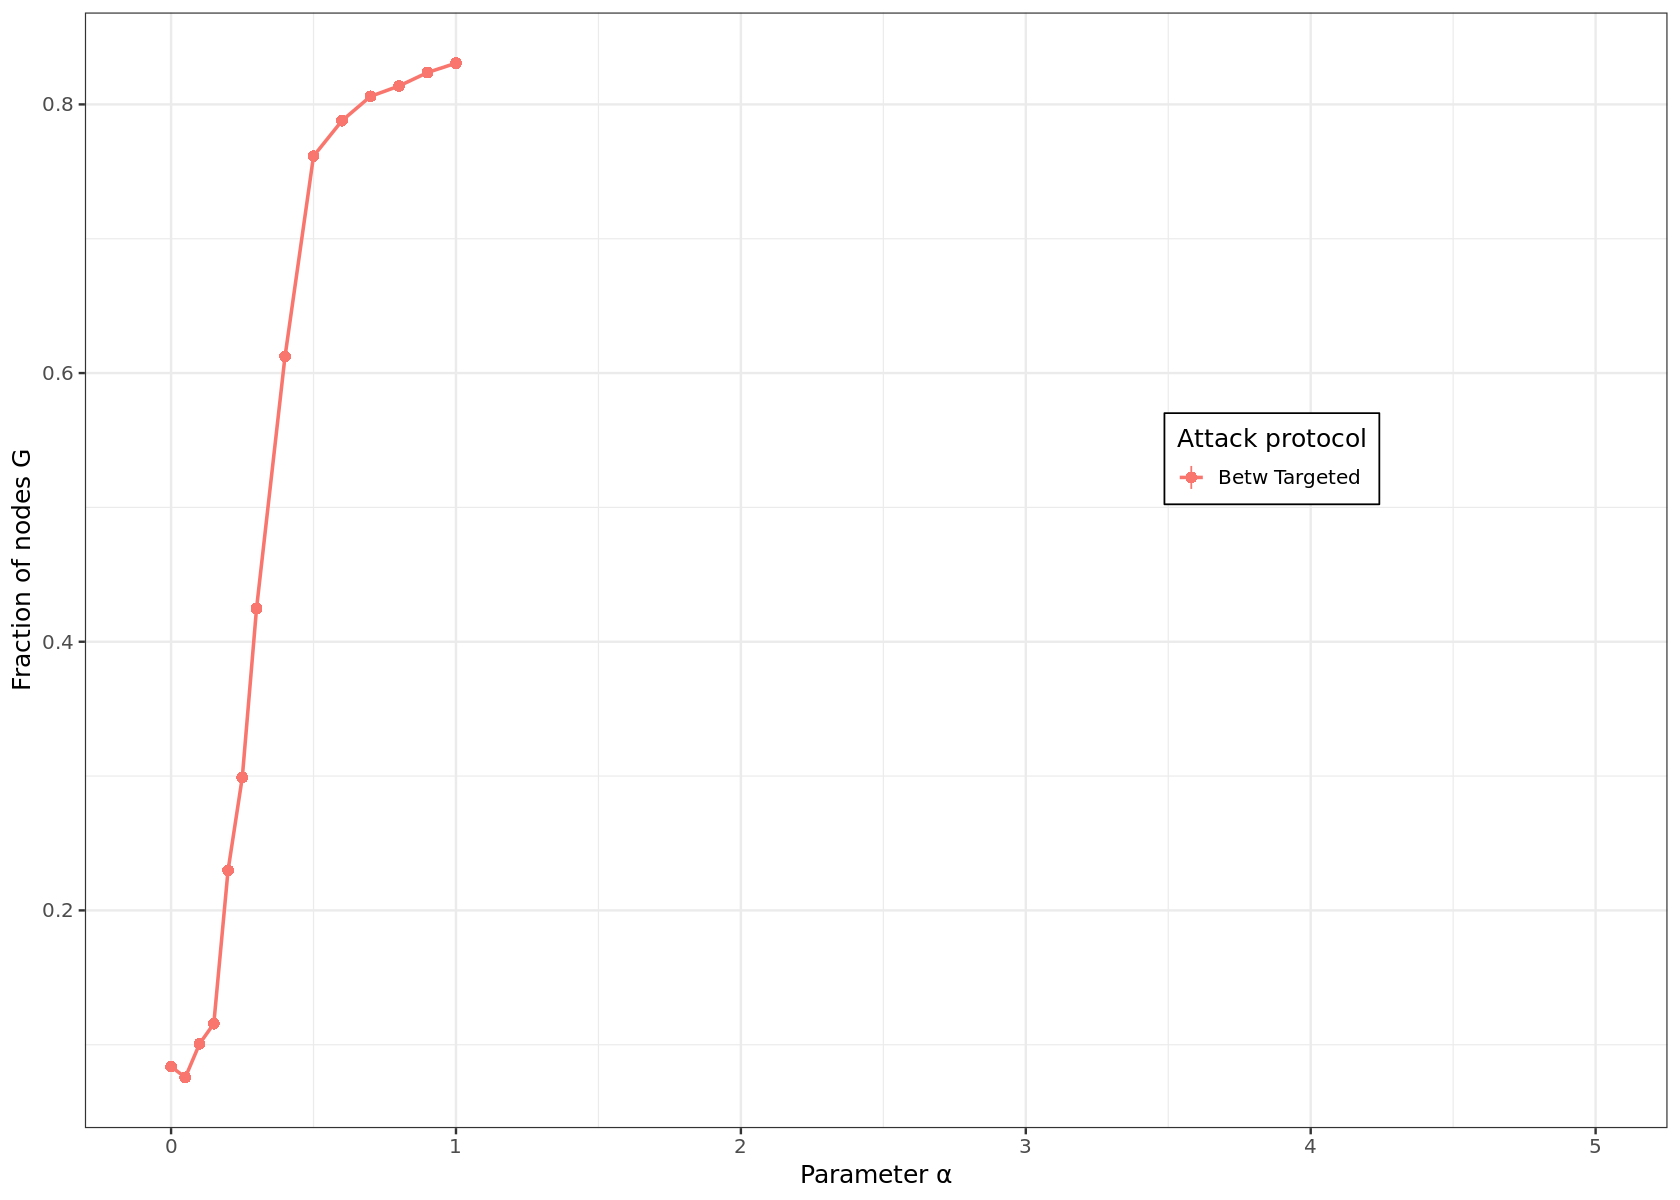

In [339]:
plot_conf_2 <- ggplot(g_ratios_2) + geom_point(aes(x = alpha, y = g_ratio, col = type),
    shape = 16, size = 3) + geom_linerange(aes(x = alpha, ymax = g_ratio + g_ratio_sd,
    ymin = g_ratio - g_ratio_sd, col = type), position = position_dodge(-0.02)) +
    geom_line(aes(x = alpha, y = g_ratio, col = type), linewidth = 1) + scale_x_continuous(limits = c(-0.05,
    5)) + labs(x = expression(paste("Parameter ", alpha)), y = "Fraction of nodes G",
    col = "Attack protocol") + theme_bw(base_size = 15) + theme(legend.position = c(0.75,
    0.6), legend.background = element_rect(size = 0.5, linetype = "solid", colour = "black"))

plot_conf_2

In [34]:
ggsave(plot = plot_conf_2, filename = 'power/plot_g_targeted_only.pdf', width = 7, height = 5)

Warning message:
“`position_dodge()` requires non-overlapping x intervals”


# select alpha and show destruction

In [365]:
alpha<-0.5

In [366]:
V(g)$cst_ids<-1:length(g)

# V(g)[index]$cst_ids

V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
V(g)$capacity <- (1 + alpha) * V(g)$load
overloaded <- order(V(g)$load, decreasing = TRUE)[1]

# overloaded

dead_nodes<-overloaded

g_or <- g

In [367]:
g_or <- delete_vertices(g_or, overloaded)
V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
overloaded <- as.vector(V(g_or)[load > capacity])

In [368]:
# hist(log(V(g_or)$load), breaks = 20)

In [369]:
orig_idx<-V(g_or)[overloaded]$cst_ids

In [370]:
orig_idx

[1]    4   13   15   22   27   34   36   39   40   41   44   51   54   55   67
 [16]   72   73   74   85   88   89   94   97  106  107  109  110  121  124  134
 [31]  147  163  177  179  185  193  195  199  202  203  213  215  216  219  222
 [46]  226  238  239  252  257  261  272  276  282  284  289  291  301  302  307
 [61]  331  341  342  367  377  379  400  450  453  456  463  466  476  478  480
 [76]  492  499  502  503  504  514  519  520  535  543  580  582  583  586  624
 [91]  625  633  634  637  641  643  655  667  678  688  695  699  706  709  713
[106]  714  715  721  727  728  733  736  739  740  742  743  744  745  750  752
[121]  767  772  774  775  795  797  800  804  806  810  813  816  819  825  828
[136]  833  837  843  845  848  850  851  858  860  863  872  876  892  900  908
[151]  926  933  942  946  952  953  956  979  984  986  994 1013 1016 1020 1029
[166] 1060 1065 1066 1067 1089 1102 1126 1133 1136 1146 1156 1163 1167 1179 1180
[181] 1184 1190 1195 1199 1201 1214 1217 1221 1223 1225 1231 1235 1260 1269 1275
[196] 1323 1324 1326 1328 1333 1352 1358 1362 1363 1368 1370 1395 1404 1406 1408
[211] 1417 1428 1441 1458 1470 1484 1491 1502 1548 1550 1552 1553 1559 1567 1585
[226] 1594 1595 1600 1606 1610 1614 1616 1618 1621 1625 1629 1632 1637 1639 1646
[241] 1655 1662 1666 1672 1677 1695 1698 1699 1702 1708 1710 1713 1736 1748 1758
[256] 1780 1785 1797 1807 1812 1814 1817 1821 1822 1830 1838 1856 1877 1895 1913
[271] 1916 1920 1925 1929 1932 1933 1942 1945 1948 1954 1959 1962 1968 1978 1984
[286] 1987 1989 1993 1994 1998 2005 2006 2011 2013 2014 2015 2018 2028 2031 2034
[301] 2039 2040 2043 2056 2059 2060 2064 2067 2070 2073 2074 2089 2108 2126 2140
[316] 2142 2143 2144 2147 2167 2172 2177 2184 2203 2211 2229 2243 2244 2278 2289
[331] 2306 2317 2346 2358 2363 2367 2377 2380 2403 2418 2423 2431 2433 2435 2436
[346] 2448 2450 2463 2466 2467 2474 2484 2490 2494 2508 2549 2554 2562 2563 2569
[361] 2572 2581 2603 2605 2612 2619 2621 2631 2638 2647 2650 2664 2667 2673 2674
[376] 2680 2696 2721 2726 2732 2733 2735 2751 2759 2769 2782 2789 2799 2814 2850
[391] 2853 2870 2871 2879 2901 2902 2913 2917 2921 2925 2931 2946 2972 2980 2982
[406] 2990 2995 3018 3030 3055 3062 3066 3067 3070 3088 3092 3095 3104 3108 3133
[421] 3145 3157 3158 3161 3176 3183 3185 3197 3235 3248 3264 3265 3269 3273 3277
[436] 3299 3318 3330 3365 3366 3369 3375 3378 3382 3395 3399 3423 3427 3433 3440
[451] 3448 3453 3458 3462 3465 3491 3502 3507 3510 3515 3519 3521 3522 3523 3528
[466] 3536 3543 3548 3558 3559 3564 3567 3589 3595 3600 3601 3604 3605 3615 3618
[481] 3619 3628 3635 3639 3647 3649 3664 3668 3670 3673 3682 3700 3704 3727 3736
[496] 3737 3738 3751 3758 3767 3771 3782 3790 3791 3796 3797 3804 3805 3812 3832
[511] 3844 3845 3851 3867 3884 3894 3910 3925 3949 3978 3981 3988 3997 4006 4011
[526] 4038 4040 4050 4064 4070 4077 4086 4090 4092 4095 4121 4122 4136 4139 4146
[541] 4149 4155 4156 4160 4165 4169 4173 4180 4182 4199 4201 4204 4227 4229 4230
[556] 4239 4240 4241 4260 4269 4278 4289 4293 4294 4298 4311 4317 4334 4347 4356
[571] 4362 4363 4371 4381 4382 4423 4437 4441 4449 4455 4459 4478 4484 4500 4512
[586] 4513 4521 4528 4538 4589 4601 4633 4654 4681 4691 4737 4740 4751 4756 4770
[601] 4775 4798 4808 4815 4843 4852 4859 4877 4878 4888 4897 4903 4908 4909 4931
[616] 4942 4957 4958 4959 4968 4984 4986 4992 5050 5063 5066 5072 5073 5101 5110
[631] 5113 5118 5127 5133 5139 5146 5147 5150 5152 5154 5156 5160 5161 5171 5174
[646] 5179 5186 5200 5203 5212 5214 5217 5218 5221 5223 5225 5234 5239 5241 5243
[661] 5247 5248 5251 5254 5255 5270 5272 5277 5282 5287 5291 5292 5303 5305 5310
[676] 5327 5329 5332 5333 5334 5335 5355 5363 5366 5368 5369 5370 5374 5384 5385
[691] 5412 5417 5422 5430 5439 5441 5448 5453 5462 5467 5488 5505 5511 5517 5525
[706] 5543 5575 5585 5586 5609 5637 5640 5642 5645 5652 5662 5665 5671 5672 5674
[721] 5690 5693 5699 5700 5705 5711 5716 5717 5720 5727 5749 5755 5766 5768 5771
[736] 5772 5774 5778 5803 5819 58

In [371]:
dead_nodes<-c(dead_nodes, orig_idx)

In [372]:
colors<-mypal[btw_col_idx]

In [373]:
colors[orig_idx]<-'#0000FF'
colors[-orig_idx]<-'#c6c6c6'
colors[index]<-'#FF0000'

In [386]:
pdf("internet/whole_graph_failing_new.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=1.5, cex.lab = 1.5, cex.main=2)
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)


x_left_2<--0.2
x_right_2<--0.1
y_top_2<--0.15
y_bottom_2<--0.25

x_left_1<-0.1
x_right_1<-0.3
y_top_1<-0.7
y_bottom_1<-0.5

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = NA, vertex.color = colors,
    vertex.label = "", edge.size = 0.05, edge.arrow.size = 0,
     axes = T,
     xlab='x dimension [au]', ylab='y dimension [au]',
#      xlim = c(0.2,0.8),
#      ylim = c(0.2, 0.6),
     rescale=F )
points(layout[index,1], layout[index,2], lwd=10, col='red')
grid()
rect(xleft = x_left_1, xright = x_right_1, ytop = y_top_1, ybottom = y_bottom_1, lwd = 2)
rect(xleft = x_left_2, xright = x_right_2, ybottom = y_bottom_2, ytop =y_top_2, lwd = 2)
# text(-1,1, paste('Affected region:', length(dead_nodes), 'nodes'), cex = 2, pos=4)
legend(-1, -0.8, legend = c(paste("Degree of first failed:", degree(g)[index]),
                            paste("Affected nodes:",length(dead_nodes))), bg='white', cex=2)

plot(g, layout = layout, vertex.size = 1.5, vertex.frame.color = alpha('grey10',0.5), vertex.color = colors,
    vertex.label = "", edge.width = NA, edge.arrow.size = 0,
     axes = T,main='Zoom on detail',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1], layout[index,2], lwd=15, col='red')
grid()

plot(g, layout = layout, vertex.size = 0.5, vertex.frame.color = alpha('grey10',0.9), vertex.color = colors,
    vertex.label = "", edge.arrow.size = 0, edge.width=NA,
     axes = T, main='Zoom on first failed node',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )
# points(layout[index,1], layout[index,2], lwd=15, col='blue')
# points(layout[index,1], layout[index,2], lwd=, col='red')

grid()
dev.off()

png 
  2

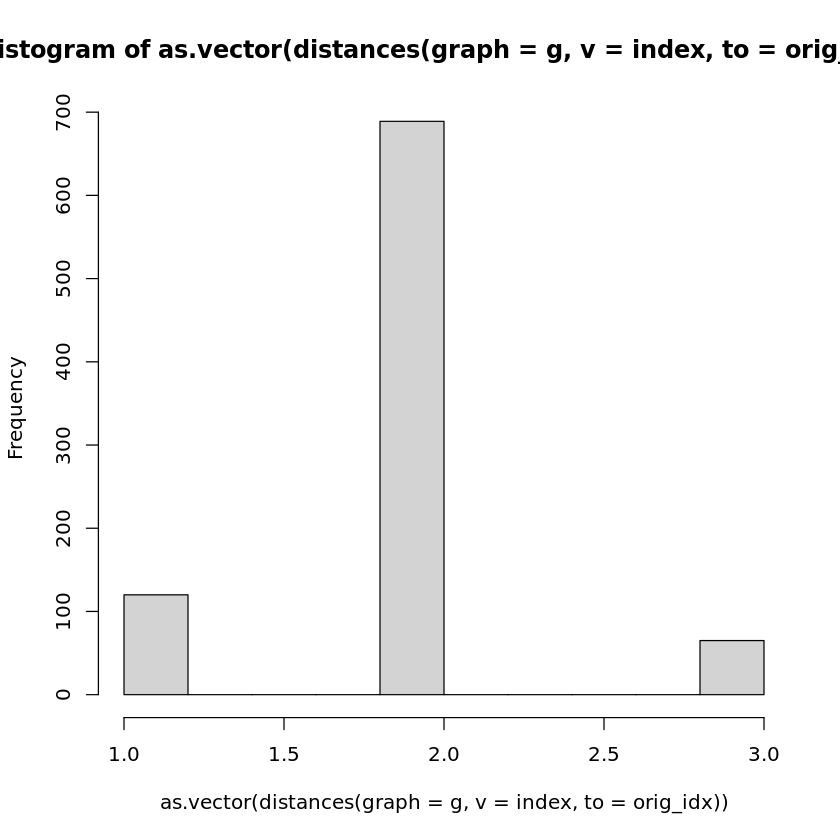

In [305]:
options(repr.plot.width=7, repr.plot.height=7)
h<-hist(as.vector(distances(graph = g, v = index, to = orig_idx)))

ERROR: Error in barplot.default(h$density, names.arg = min(h$breaks):(max(h$breaks) - : incorrect number of names


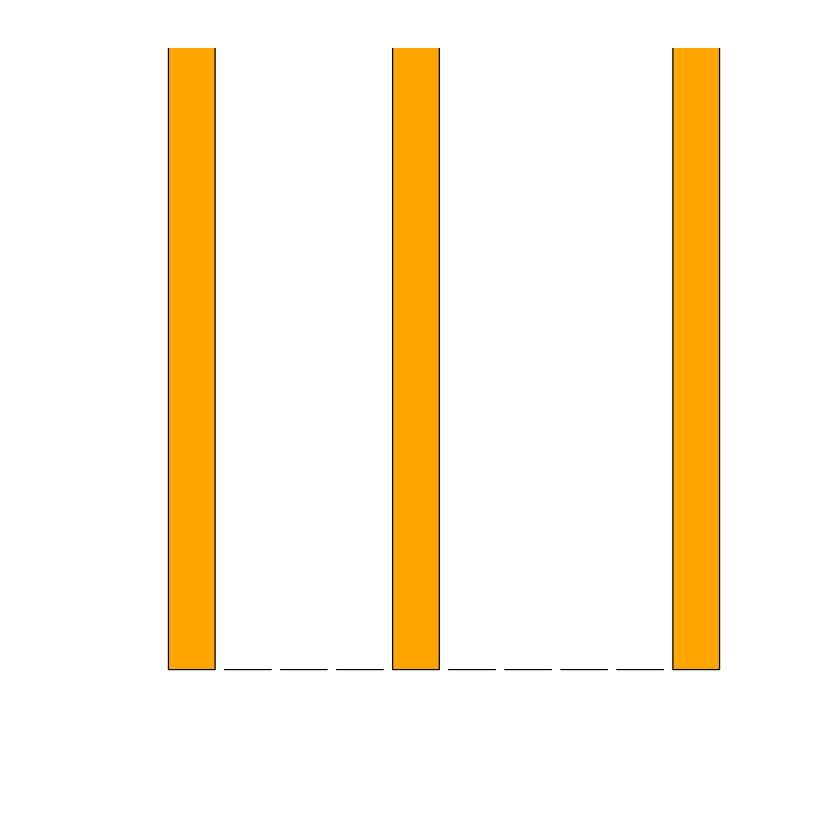

In [306]:
# pdf("power/distance_first_failed.pdf",width=7, height = 7)
par(cex.lab = 1.5, oma=c(2,2,2,2))
bp<-barplot(h$density, names.arg =min(h$breaks):(max(h$breaks)-1), xlab = "Distance from first failed node",
    ylab = "Frequency [%]", main='', col='orange', ylim=c(0,0.3))
text(bp, h$density + 0.02,paste('#:',h$counts))
grid()
# dev.off()

In [307]:
g_or <- delete_vertices(g_or, overloaded)
V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
overloaded <- as.vector(V(g_or)[load > capacity])

In [308]:
orig_idx<-V(g_or)[overloaded]$cst_ids

In [309]:
orig_idx

[1]  258  322  346  442  469  496  548  554  757 1154 1247 1265 1273 1276 1383
[16] 1405 1468 1471 1551 1784 2125 2149 2414 2584 2615 2620 2624 2656 2659 2699
[31] 2746 2753 2790 2794 2890 2934 2996 3073 3219 3346 3679 3690 3703 3905 3921
[46] 3930 3946 3973 3985 3990 4043 4072 4076 4084 4426 4435 4452 4461 4505 4559
[61] 4563 4662 4706 4743 4745 4801 4806 4861 5148 5304 5521 5724 6077 6088 6124
[76] 6402 6472

In [310]:
dead_nodes<-c(dead_nodes, orig_idx)

In [311]:
colors[dead_nodes]<-'#0000FF'
colors[-dead_nodes]<-'#c6c6c6'
colors[index]<-'#FF0000'

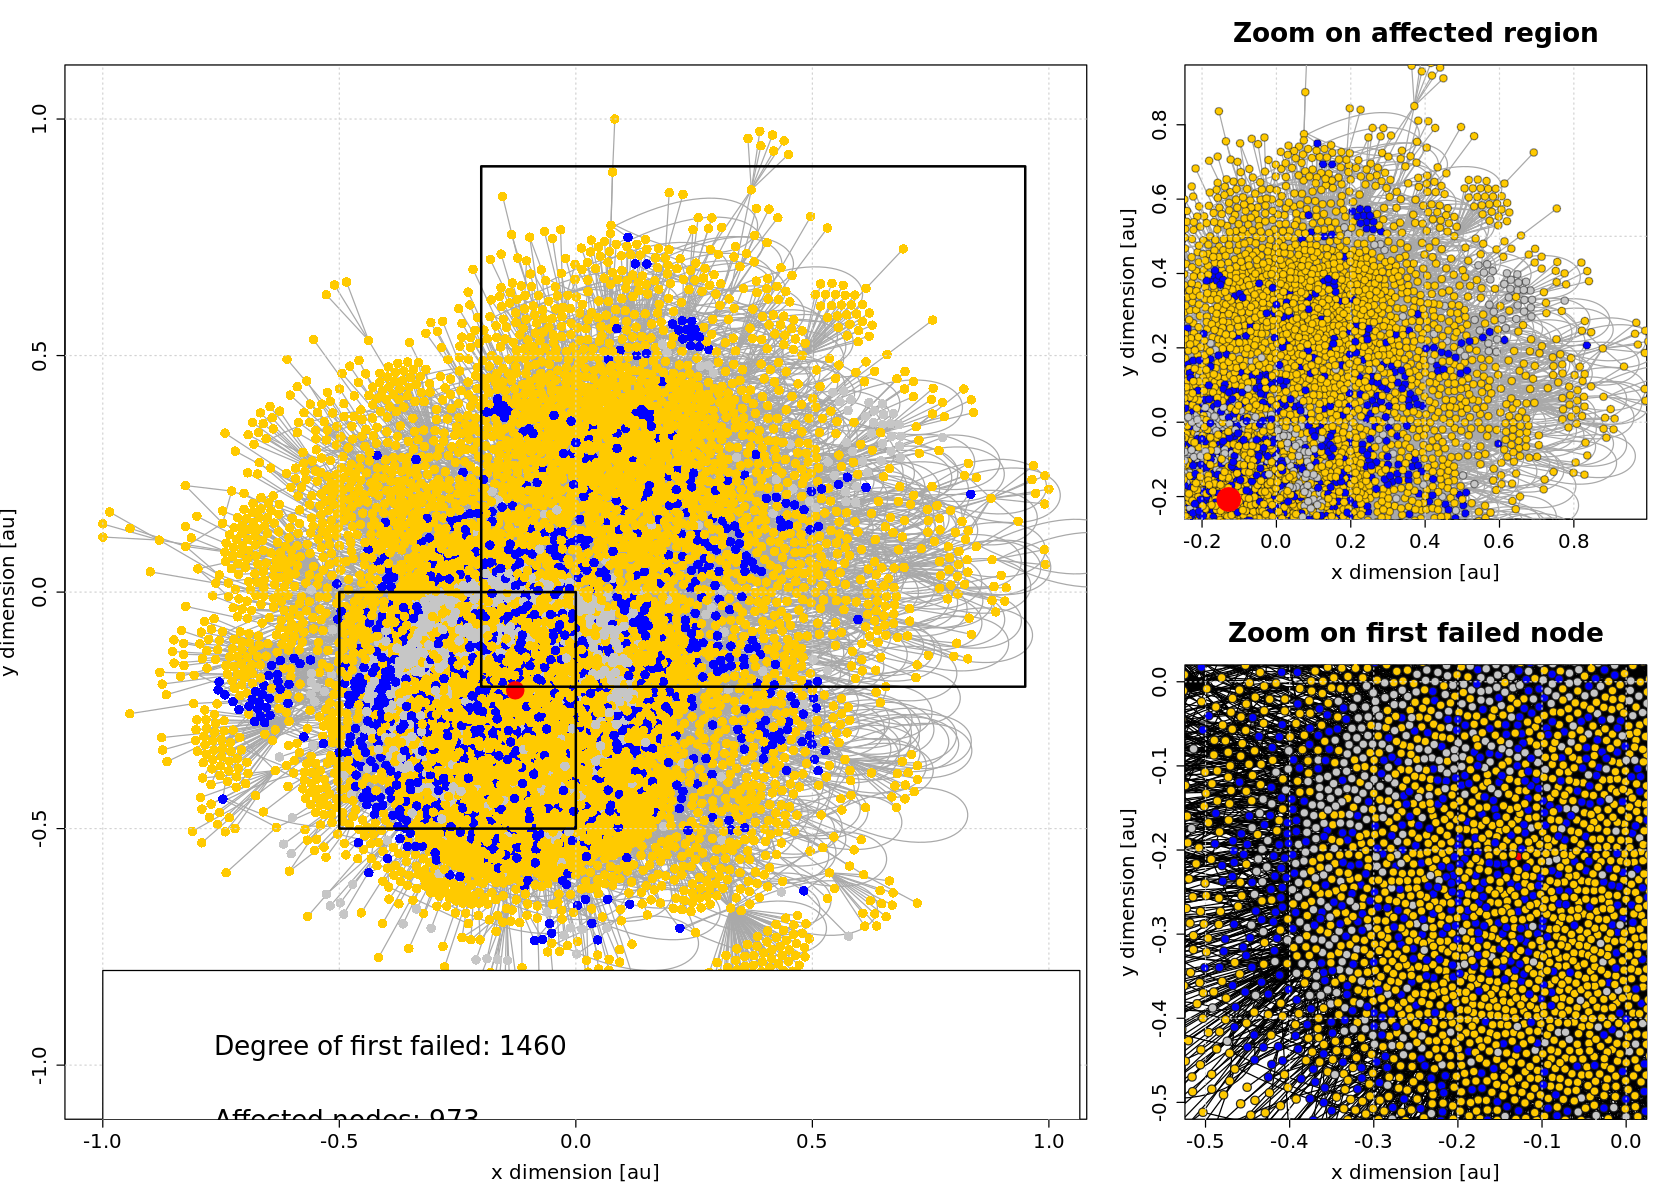

In [341]:
# pdf("power/whole_graph_failing_2.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=1.5, cex.lab = 1.5, cex.main=2)
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)


x_left_1<--0.2
x_right_1<-0.95
y_top_1<-0.9
y_bottom_1<--0.2

x_left_2<--0.5
x_right_2<-0
y_top_2<-0
y_bottom_2<--0.5

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = NA, vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,
     xlab='x dimension [au]', ylab='y dimension [au]',
#      xlim = c(0.2,0.8),
#      ylim = c(0.2, 0.6),
     rescale=F )
points(layout[index,1], layout[index,2], lwd=10, col='red')
grid()
rect(xleft = x_left_1, xright = x_right_1, ytop = y_top_1, ybottom = y_bottom_1, lwd = 2)
rect(xleft = x_left_2, xright = x_right_2, ybottom = y_bottom_2, ytop =y_top_2, lwd = 2)
# text(-1,1, paste('Affected region:', length(dead_nodes), 'nodes'), cex = 2, pos=4)
legend(-1, -0.8, legend = c(paste("Degree of first failed:", degree(g)[index]),
                            paste("Affected nodes:",length(dead_nodes))), bg='white', cex=2)

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = alpha('grey10',0.5), vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,main='Zoom on affected region',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1], layout[index,2], lwd=15, col='red')
grid()

plot(g, layout = layout, vertex.size = 1, vertex.frame.color = alpha('grey10',0.9), vertex.color = colors,
    vertex.label = "", edge.size = 0.5, edge.arrow.size = 0, edge.color='black',
     axes = T, main='Zoom on first failed node',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )
# points(layout[index,1], layout[index,2], lwd=15, col='blue')
# points(layout[index,1], layout[index,2], lwd=, col='red')

grid()
# dev.off()

In [313]:
V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
V(g)$capacity <- (1 + alpha) * V(g)$load
overloaded <- order(V(g)$load, decreasing = TRUE)[1]

dead_nodes<-overloaded
g_or <- g

counts<-0
while (length(overloaded) > 0) {
    g_or <- delete_vertices(g_or, overloaded)
    V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
    overloaded <- as.vector(V(g_or)[load > capacity])
    orig_idx<-V(g_or)[overloaded]$cst_ids
    dead_nodes<-c(dead_nodes, orig_idx)
    counts<-counts+1
}


n_prime <- max(components(g_or)$csize)
n_orig <- max(components(g)$csize)

# return(n_prime/n_orig)

In [333]:
counts

[1] 5

In [314]:
biggest_cluster_id <- which.max(components(g_or)$csize)

# ids
vert_ids <- V(g_or)[components(g_or)$membership == biggest_cluster_id]

llc_id<-V(g_or)[vert_ids]$cst_ids

In [315]:
colors[dead_nodes]<-'#0000FF'
colors[-dead_nodes]<-'#c6c6c6'
colors[index]<-'#FF0000'
colors[llc_id]<-'#ffca00'

In [331]:
pdf("internet/whole_graph_failing_all.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=1.5, cex.lab = 1.5, cex.main=2)
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)



x_left_1<-0.
x_right_1<-0.4
y_top_1<-0.7
y_bottom_1<-0.3

x_left_2<--0.2
x_right_2<--0.1
y_top_2<--0.15
y_bottom_2<--0.25


plot(g, layout = layout, vertex.size = 2, vertex.frame.color =alpha('grey10',0.5), vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,
     xlab='x dimension [au]', ylab='y dimension [au]',
#      xlim = c(0.2,0.8),
#      ylim = c(0.2, 0.6),
     rescale=F )
points(layout[index,1], layout[index,2], lwd=10, col='red')
grid()
rect(xleft = x_left_1, xright = x_right_1, ytop = y_top_1, ybottom = y_bottom_1, lwd = 2)
rect(xleft = x_left_2, xright = x_right_2, ybottom = y_bottom_2, ytop =y_top_2, lwd = 2)
# text(-1,1, paste('Affected region:', length(dead_nodes), 'nodes'), cex = 2, pos=4)
legend(-1, -0.8, legend = c(paste("Degree of first failed:", degree(g)[index]),
                            paste("Affected nodes:",length(dead_nodes)),
                            paste('Fraction in LCC:', round(n_prime/n_orig,2)*100, '%')), bg='white', cex=2)

plot(g, layout = layout, vertex.size = 1, vertex.frame.color = alpha('grey10',0.5), vertex.color = colors,
    vertex.label = "", edge.width = 0.5, edge.arrow.size = 0,
     axes = T,main='Zoom on detail',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1], layout[index,2], lwd=15, col='red')
grid()

plot(g, layout = layout, vertex.size = 0.5, vertex.frame.color = alpha('grey10',0.9), vertex.color = colors,
    vertex.label = "", edge.width = 0.1, edge.arrow.size = 0,
     axes = T, main='Zoom on first failed node',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )
# points(layout[index,1], layout[index,2], lwd=15, col='blue')
# points(layout[index,1], layout[index,2], lwd=, col='red')

grid()
dev.off()

png 
  2

# Refer to script

In [318]:
# conf<-read.csv('power/null_config.csv')

In [319]:
# plot_conf <- ggplot(conf) + geom_point(aes(x = alpha, y = g_ratio, col = type), position = position_dodge(0.02),
#     shape = 16, size = 3) + geom_line(aes(x = alpha, y = g_ratio, col = type), linewidth = 1, position = position_dodge(0.02)) +
#     scale_x_continuous(limits = c(0, 1)) + labs(x = expression(paste("Parameter ",
#     alpha)), y = "G, Fraction of nodes still alive", title = "Null model comparison",
#     col = "Attack protocol") + theme_bw(base_size = 15) + theme(legend.position = c(0.75,
#     0.2), legend.background = element_rect(size = 0.5, linetype = "solid", colour = "black"))

# plot_conf

In [320]:
# ggsave(plot = plot_conf, filename = 'power/plot_conf.pdf', width = 7, height = 5)